#### Let's try to measure parallax in DES proper motions.

After we go into a Gnomonic projection for RA and DEC (center of tile should be enough), we are going to minimize the following model:
$$ \boldsymbol\theta = \boldsymbol\theta_0 + \boldsymbol\mu (t - t_0) - \varpi \mathbf{x}_{\mathrm{E}}(t). $$

Let us linearize this:
$$\mathbf{Y} = \mathbf{A} \mathbf{X} $$
where 
$$ \mathbf{A} = \begin{pmatrix} 1 & 0 & t - t_0 & 0 &  -x_\mathrm{E} \\ 0 & 1 & 0 & t - t_0 & -y_\mathrm{E} \end{pmatrix}, $$
$$ \mathbf{X} = \begin{pmatrix} \theta_x \\ \theta_y \\ \mu_x \\ \mu_y \\ \varpi \end{pmatrix}. $$

So the minimization to this model is 
$$ \mathbf{X}= [\mathbf{A}^\top \mathbf{C}^{-1} \mathbf{A}]^{-1} [\mathbf{A}^\top \mathbf{C}^{-1} \mathbf{Y}], $$
with uncertainties
$$ \Sigma = [\mathbf{A}^\top \mathbf{C}^{-1} \mathbf{A}]^{-1}. $$

We're also adding a prior for the parallax term, so the fit is actually for
$$\chi^2 = (\mathbf{Y} - \mathbf{A} \mathbf{X})^\top \mathbf{C}^{-1} (\mathbf{Y} - \mathbf{A} \mathbf{X}) + \frac{\varpi^2}{\sigma_\varpi^2}.$$

In [1]:
import data_management as dm
import proper as pr
import numpy as np 
import astropy.table as tb
from scipy.linalg import block_diag
from scipy.linalg import solve
pl.style.use('../des.mplstyle')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 9

In [2]:
exposures = tb.Table.read('y4a1.exposure.positions.fits')

In [3]:
def make_matrices(data, maps, exposures, t0, RA_0, DEC_0, mu=0, sigma = 0.01, parallax = True, prior = True):
    '''
    Builds the matrices required for the proper motion fit (as defined above), including parallax
    '''
    #data, sigma, sigma_inv = get_data(group, maps)
    A = []
    Y = []
    C = []
    
    
    R_bl = np.array([[-np.sin(RA_0), np.cos(RA_0), 0],[-np.cos(RA_0)*np.sin(DEC_0), -np.sin(RA_0)*np.sin(DEC_0), np.cos(RA_0)],[np.cos(RA_0)*np.cos(DEC_0), np.sin(RA_0)*np.cos(DEC_0), np.sin(RA_0)]])

    for i in data:
        exp = exposures[exposures['expnum'] == i['EXPNUM']]
        if not exp['covwarn'] and len(exp) > 0:
            if parallax:
                obs = R_bl.dot(exp['observatory'][0].T)
                A.append([1, 0, (exp['mjd_mid'] - t0)/365.25, 0, -obs[0]])
                A.append([0, 1, 0, (exp['mjd_mid'] - t0)/365.25, -obs[1]])
            else:
                obs = [0, 0]
                A.append([1, 0, (exp['mjd_mid'] - t0)/365.25, 0])
                A.append([0, 1, 0, (exp['mjd_mid'] - t0)/365.25])
            
            C.append(np.linalg.inv(np.array([[i['ERRAWIN_WORLD']**2, 0],[0, i['ERRAWIN_WORLD']**2]]) + maps.getCovariance(i['EXPNUM'])/(1000.*3600.)**2))
            Y.append(i['THETA_X'])
            Y.append(i['THETA_Y'])
    
    #parallax prior
    if prior:
        A.append([0,0,0,0,1])
        Y.append(mu/3600.)
        C.append([(1./(sigma/3600.))**2])
    
    
    #transform matrices into something usable
    A = np.array(A)
    Y = np.array(Y)
    C = block_diag(*C)
    return A, Y, C  



In [4]:
def solve_proper(group, maps, exposure, t0, RA_0, DEC_0, mu=0, sigma=0.01, parallax = True, prior = True):
    A, Y, C_inv = make_matrices(group, maps, exposures, t0, RA_0 * np.pi/180., DEC_0 * np.pi/180., mu, sigma, parallax, prior)
    n_dof = 5 if parallax else 4
    B = np.linalg.multi_dot([A.T, C_inv, A])
    
    D = np.linalg.multi_dot([A.T, C_inv, Y])
    
    
    Sigma = np.linalg.inv(B)
    X = solve(B, D, check_finite=False)
    
    Delta = (Y - A.dot(X))
    chisq = np.linalg.multi_dot([Delta.T, C_inv, Delta])
    if parallax:
        X[4] = 3600*X[4]

    return X, Sigma, chisq/(2*len(group) - n_dof), Delta





In [5]:
a = tb.Table.read('/Volumes/folio/data3/garyb/tno/matcher/zone029/DES0146-0707_final.fits')


In [6]:
b = a[a['MATCH_ID'] == 12405]

In [7]:
b.show_in_notebook()

idx,RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
0,26.149065,-7.2714479999999995,7.577049814244674e-07,1009.0833740234375,2110.8173828125,-0.0007688810001127422,0.00018401800480205566,142054.0,954.3099975585938,379928,0,7.538570230281039e-07,1.945770025253296,-9999.0,1.8717600107192993,-9999.0,-81.06849670410156,72.97530364990234,-9999.0,8.764780147865227e-15,39,i,56982.08944841,90.0,31.680870056152344,y4a1_v1.5,-0.361186508943138,-0.14953330871196568,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,12405.0,0.61,26.149113658263907,-7.271464710250534
1,26.149297999999998,-7.271561999999999,4.428480224305531e-06,48.63876724243164,1206.640869140625,-0.001956090098246932,0.0010168800363317132,13267.900390625,468.42999267578125,588992,0,4.386999989947071e-06,1.9229799509048462,-9999.0,1.746840000152588,-9999.0,-61.747501373291016,29.564899444580078,-9999.0,3.5123199921410775e-12,44,r,57695.24678389,90.0,31.650196075439453,y4a1_v1.5,-0.360998724661448,-0.14962731604032345,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,12405.0,0.61,26.14930288217313,-7.271558866042413
2,26.149067,-7.2714479999999995,4.150080030740355e-07,1687.9866943359375,1064.04296875,-8.722829807084054e-05,0.00010837899753823876,392896.0,1393.68994140625,381808,0,4.1241600001740153e-07,2.228559970855713,-9999.0,2.1479198932647705,-9999.0,-17.078500747680664,-88.0447006225586,-9999.0,7.407109894347764e-16,58,z,56988.07358833,90.0,31.042695999145508,y4a1_v1.5,-0.3611883723593617,-0.14953686967278088,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,12405.0,0.61,26.149111776993124,-7.271468269616451
3,26.149171,-7.271477,5.241839971859008e-06,327.3446960449219,3811.388916015625,-0.0028418300207704306,0.0010566100245341659,13598.599609375,490.7560119628906,464911,0,5.226109806244494e-06,2.0262200832366943,-9999.0,1.8243800401687622,-9999.0,5.130770206451416,-17.17650032043457,-9999.0,3.0652299275180095e-12,15,r,57252.40858821,90.0,31.61612319946289,y4a1_v1.5,-0.3611296162540023,-0.14954555303556427,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,12405.0,0.61,26.149171,-7.271477
4,26.149171,-7.271506,2.743690004081145e-07,335.17535400390625,3860.084228515625,0.00024441300774924457,7.463640213245526e-05,514243.0,1174.8900146484375,488829,0,2.635879923218454e-07,2.133280038833618,-9999.0,2.006119966506958,-9999.0,-24.98870086669922,48.551700592041016,-9999.0,8.442279976494677e-16,15,z,57327.2107331,90.0,31.334304809570312,y4a1_v1.5,-0.36108568600440927,-0.14958341471732733,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,12405.0,0.61,26.149215254431628,-7.271514895986473
5,26.149051,-7.271452,4.0045699734037044e-07,1577.2899169921875,2098.398193359375,-0.00014392699813470244,0.00010502099758014083,462197.0,1503.5699462890625,367553,0,3.976250013693061e-07,2.487370014190674,-9999.0,2.387939929962158,-9999.0,61.06340026855469,-28.22260093688965,-9999.0,5.789530016185043e-16,30,z,56944.22687998,90.0,31.220067977905273,y4a1_v1.5

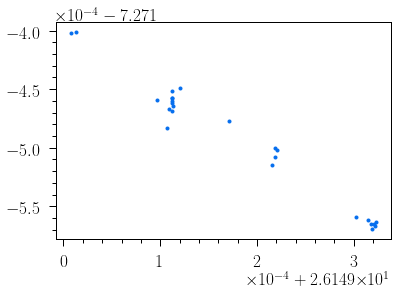

In [8]:
pl.plot(b['NEW_RA'], b['NEW_DEC'], '.')
pl.show()

In [9]:
b['THETA_X'], b['THETA_Y'] = dm.radec_to_gnomonic(b['NEW_RA'], b['NEW_DEC'], b['NEW_RA'][0], b['NEW_DEC'][0])


In [10]:
from pixmappy import DESMaps
pmc = DESMaps()

In [11]:
b = b[b['VERSION'] != 'COADD']
solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], mu=0, sigma=0.00001, parallax=True, prior=True)[0][4]




/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


4.300325310644312e-07

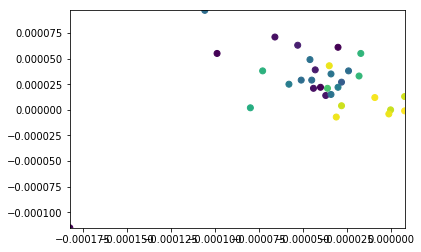

In [30]:
pl.scatter(b['THETA_X'], b['THETA_Y'], c = b['MJD_OBS'])
pl.xlim(np.min(b['THETA_X']), np.max(b['THETA_X']))
pl.ylim(np.min(b['THETA_Y']), np.max(b['THETA_Y']))

pl.show()

In [14]:
x_res = []
y_res = []

for i in range(len(Delta)):
    if i%2 == 0:
        x_res.append(Delta[i])
    else:
        y_res.append(Delta[i])





NameError: name 'Delta' is not defined

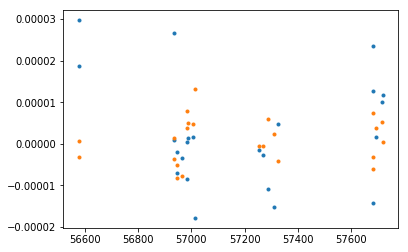

In [57]:
pl.plot(b['MJD_OBS'][:-1], x_res[:-1], '.')
pl.plot(b['MJD_OBS'][:-1], y_res, '.')

pl.show()

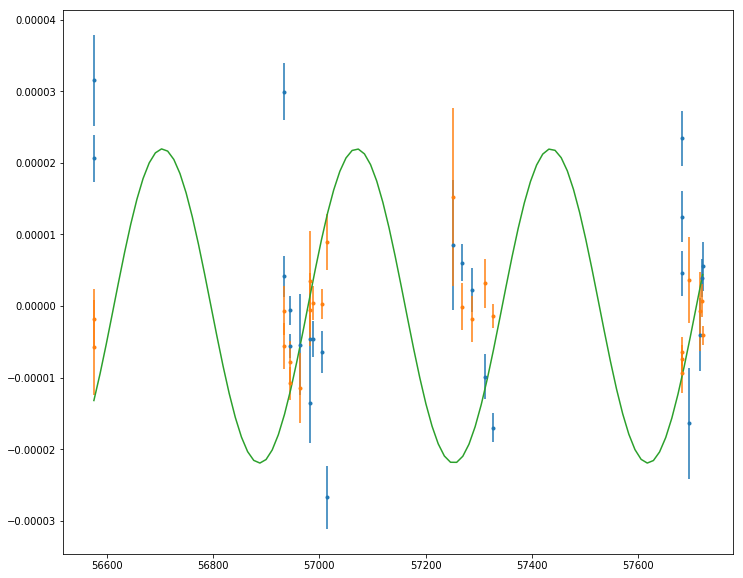

In [60]:
fig = pl.figure()
fig.set_size_inches(12,10)
pl.errorbar(b['MJD_OBS'], b['THETA_X'] - X[0] - (b['MJD_OBS'] -57205)/365.25 * X[2], fmt='.', yerr = b['ERRAWIN_WORLD'] + np.array(x_Cov))
pl.errorbar(b['MJD_OBS'], b['THETA_Y']  - X[1] - (b['MJD_OBS'] -57205)/365.25 * X[3], fmt='.', yerr = b['ERRAWIN_WORLD'] + np.array(y_Cov))
pl.plot(np.linspace(np.min(b['MJD_OBS']), np.max(b['MJD_OBS']),100), 79./1000./3600 * np.sin(2*np.pi*np.linspace(np.min(b['MJD_OBS']), np.max(b['MJD_OBS']),100)/365.25))
pl.show()

In [98]:
b.sort('MJD_OBS')
b['MAG'] = -2.5*np.log10(b['FLUX_AUTO']) + b['MAG_ZERO']
b['MJD_OBS', 'XWIN_IMAGE', 'YWIN_IMAGE', 'BAND', 'EXPNUM', 'MAG'].show_in_notebook()

idx,MJD_OBS,XWIN_IMAGE,YWIN_IMAGE,BAND,EXPNUM,MAG
0,56576.20702567,1673.998779296875,1042.15966796875,r,242767,21.290103765973058
1,56576.2083894,1679.82421875,1047.469970703125,i,242768,18.77551991776333
2,56933.25731437,1067.3807373046875,2025.461669921875,Y,365084,16.47148458741925
3,56933.25816361,1630.273193359375,2077.345458984375,i,365085,18.798887590591157
4,56944.22466262,1665.611328125,1084.9637451171875,Y,367551,16.479785756806343
5,56944.22687998,1577.2899169921875,2098.398193359375,z,367553,17.058000172254786
6,56964.25287572,1623.759765625,2144.39794921875,Y,374554,16.47810667776125
7,56982.08806761,988.1407470703125,2115.67333984375,r,379927,21.235053008074274
8,56982.08944841,1009.0833740234375,2110.8173828125,i,379928,18.79973638808223
9,56988.07358833,1687.9866943359375,1064.04296875,z,381808,17.057001980735045


In [59]:
x_Cov = []
y_Cov = []

for i in b:
    cov = pmc.getCovariance(i['EXPNUM'])
    x_Cov.append(np.sqrt(cov[0,0]/(1000*3600)**2))
    y_Cov.append(np.sqrt(cov[1,1]/(1000*3600)**2))



In [50]:
print exposures[exposures['expnum'] == 242767]['ra', 'dec']
print exposures[exposures['expnum'] == 242768]['ra', 'dec']

      ra           dec      
------------- --------------
26.0670424739 -6.48367385261
      ra           dec      
------------- --------------
26.0667561739 -6.48325902337


In [100]:
1.0552823e-05 * 3600 *1000

37.9901628

In [84]:
np.sqrt( 1.44457684e-12) * 3600 * 1000

4.326859813583056

In [103]:
wcs = pmc.getDESWCS(int(b[0]['EXPNUM']), int(b[0]['CCDNUM']))


In [107]:
np.array(wcs.toSky(b[0]['XWIN_IMAGE'], b[0]['YWIN_IMAGE'], c = 6)) - np.array(wcs.toSky(b[0]['XWIN_IMAGE'], b[0]['YWIN_IMAGE'], c = 0.61))

array([-6.53312412e-07, -4.35415725e-06])

In [105]:
wcs.toSky(b[0]['XWIN_IMAGE'], b[0]['YWIN_IMAGE'], c = 6)

(26.149012003331176, -7.271405223738694)

In [112]:
np.sqrt( 1.44853165e-12)*3600*1000

4.332778575464017

In [17]:
#print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 100000000, True, True)[0][4]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.1, True, True)[0]

print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.01, True, True)[0]
#print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0.005, 0.001, True, True)[0][4]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.0012, True, True)[0]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.00012, True, True)[0]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.000012, True, True)[0]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.00012, False, False)[0]




/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


[ 6.98385249e-05 -2.30220588e-05  1.03190449e-04 -5.18846035e-05
  8.05098344e-02]
[ 6.97676423e-05 -2.40506296e-05  1.02892125e-04 -5.19166092e-05
  6.79210232e-02]
[ 6.94175873e-05 -2.91302423e-05  1.01418848e-04 -5.20746698e-05
  5.75098624e-03]
[ 6.93855542e-05 -2.95950719e-05  1.01284030e-04 -5.20891337e-05
  6.18775100e-05]
[ 6.93852092e-05 -2.96000770e-05  1.01282578e-04 -5.20892895e-05
  6.19245392e-07]
[ 6.93852058e-05 -2.96001276e-05  1.01282564e-04 -5.20892910e-05]


In [19]:
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.1, True, True)[2]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0.005, 0.01, True, True)[2]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.0012, True, True)[2]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.00012, True, True)[2]
print solve_proper(b, pmc, exposures, 57205, b['NEW_RA'][0], b['NEW_DEC'][0], 0, 0.000012, False, False)[2]



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


2.0621396054518635
3.1680624930480836
9.538629860373504
10.107586807194643
9.88391653523338


In [57]:
print np.sqrt(solve_proper(b, pmc, exposures, 57205, 24.614, -7.271,0,0.01, True, True)[1][4,4])*3600
print np.sqrt(solve_proper(b, pmc, exposures, 57205, 24.614, -7.271,0.005,0.001, True, True)[1][4,4])*3600
print np.sqrt(solve_proper(b, pmc, exposures, 57205, 24.614, -7.271,0,0.0012, True, True)[1][4,4])*3600

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


0.004349717183830952
0.004349717183830709
0.004349717183830783


In [29]:
len(b)

26

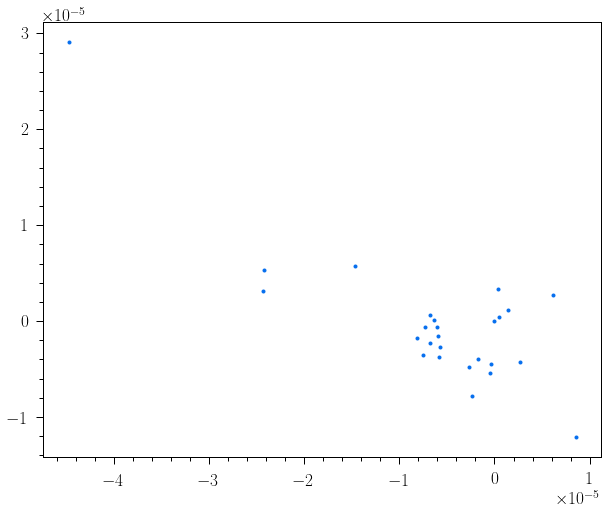

In [49]:
pl.plot(b['THETA_X'], b['THETA_Y'], '.')
pl.show()

In [55]:
exposures[exposures['expnum'] == 242767]['observatory'][0]

array([0.95072416, 0.27869451, 0.12069822])

In [60]:
RA_0 = b['NEW_RA'][0]*np.pi/180
DEC_0 = b['NEW_DEC'][0]*np.pi/180
R_bl = np.array([[-np.sin(RA_0), np.cos(RA_0), 0],[-np.cos(RA_0)*np.sin(DEC_0), -np.sin(RA_0)*np.sin(DEC_0), np.cos(RA_0)],[np.cos(RA_0)*np.cos(DEC_0), np.sin(RA_0)*np.cos(DEC_0), np.sin(RA_0)]])



In [63]:
R_bl.dot(exposures[exposures['expnum'] == 242767]['observatory'][0]), R_bl.dot(exposures[exposures['expnum'] == 242767]['observatory'][0].T)

(array([-0.4961785 ,  0.40517462,  0.88220125]),
 array([-0.4961785 ,  0.40517462,  0.88220125]))

In [64]:
b['THETA_X']

0.0
-3.6781690002628274e-07
8.578594936620456e-06
-8.175742267556163e-06
-7.5036305056017725e-06
-1.4690758722408355e-05
-5.795120955363012e-06
-4.2200393380106433e-07
-2.436381219313556e-05
-6.742194926417913e-06
-6.8068552977588195e-06
